# Obligatorio de Análisis Predictivo de Series Temporales


## Conteo de vehículos

## Estudiantes: Felipe Bastarrica y Emiliano Espíndola


In [1]:
#install.packages("feasts")
#cargo bibliotecas
library(astsa)
library(forecast)


#ajusto tamaño de gráficas
options(repr.plot.width=15, repr.plot.height=8)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas




In [2]:
# Datos extraidos de https://catalogodatos.gub.uy/dataset/intendencia-montevideo-conteo-de-vehiculos-del-centro-de-gestion-de-la-movilidad

# Carga de datos preprocesados - Son datos para la calle Sarmiento de rambla a 
# requena del 1-1-2017 al 31-12-2018 sumarizado en 3 detectores sin contar sabados y domingos.
df <- read.csv("./volumen_Sarmiento_15_2017_092019.csv", )


In [ ]:
head(df)
weekend_days = 0

# Frecuencia de muestreo por 15 min
freq = ((365-weekend_days)*24*60)/(3*5)
freq_aux = ((365-weekend_days)*24*60)/(3*5*52)
# Frecuencia por semana
#freq = (365-weekend_days)/(5)
freq

In [4]:
# Definición de Time Series (no se coloca la referencia en 2017 por ahora)
df_ts = ts(df$volumen15, frequency=freq, start=c(2017,1))
df_ts_aux = ts(df$volumen15, frequency=freq_aux, start=c(2017,1))


[1] 82.34276

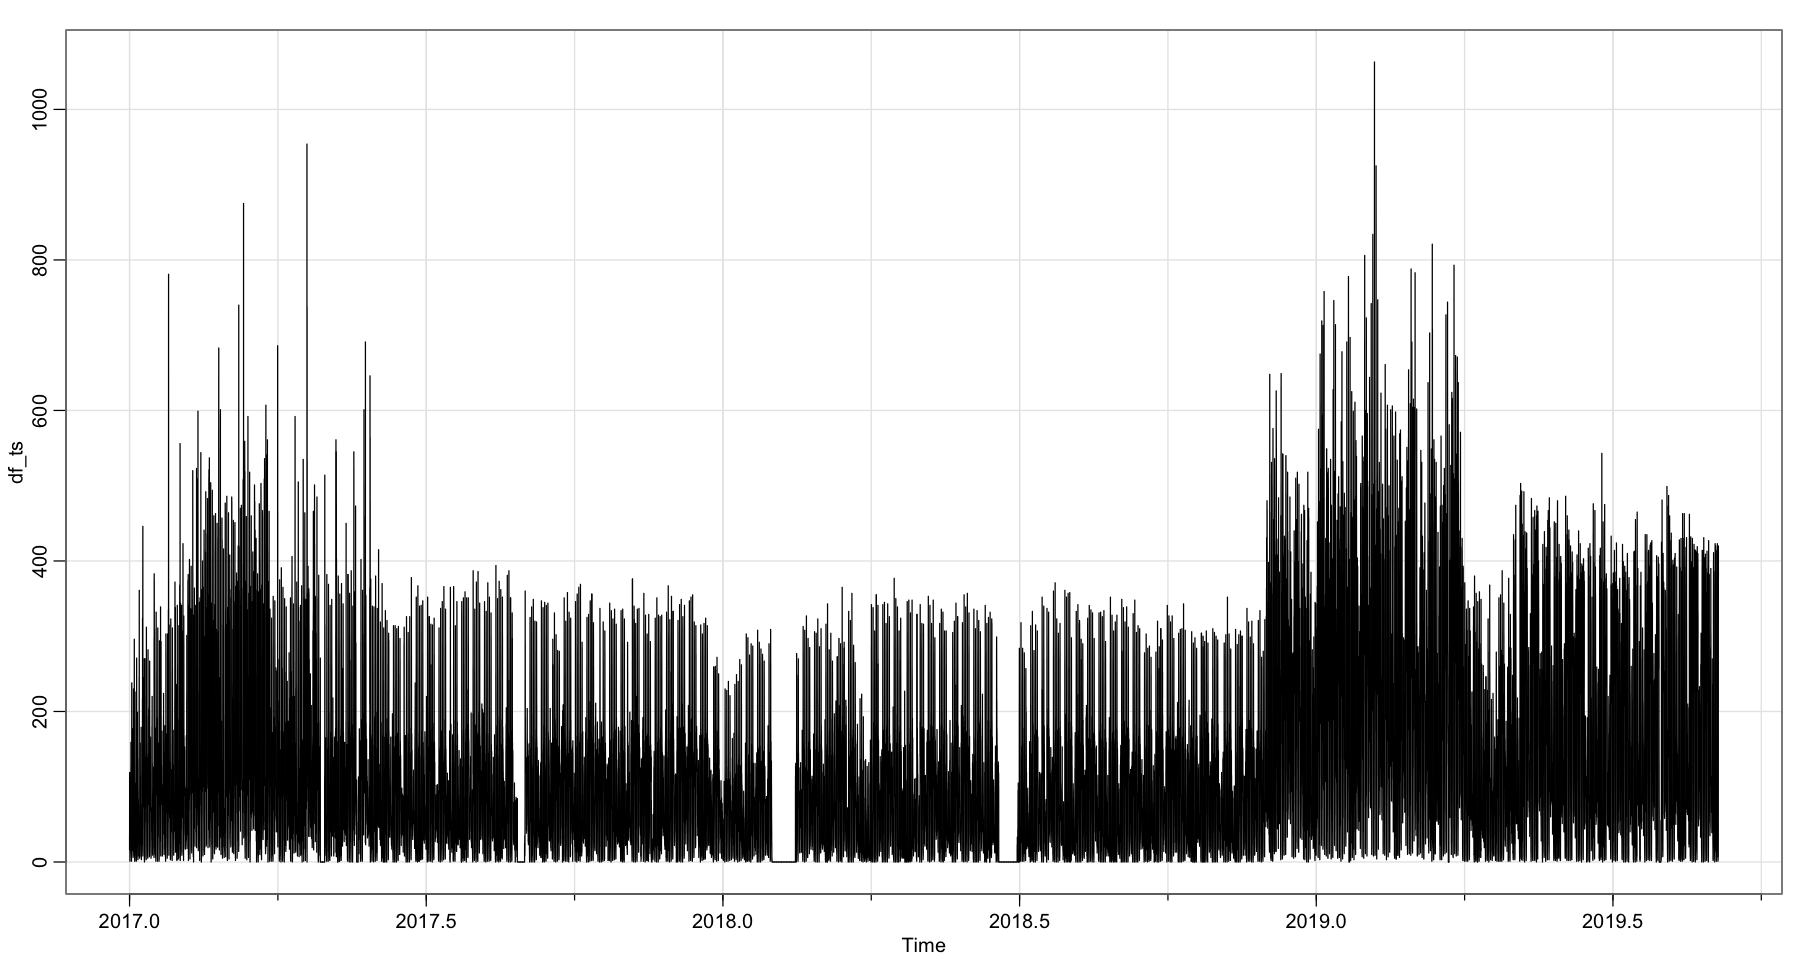

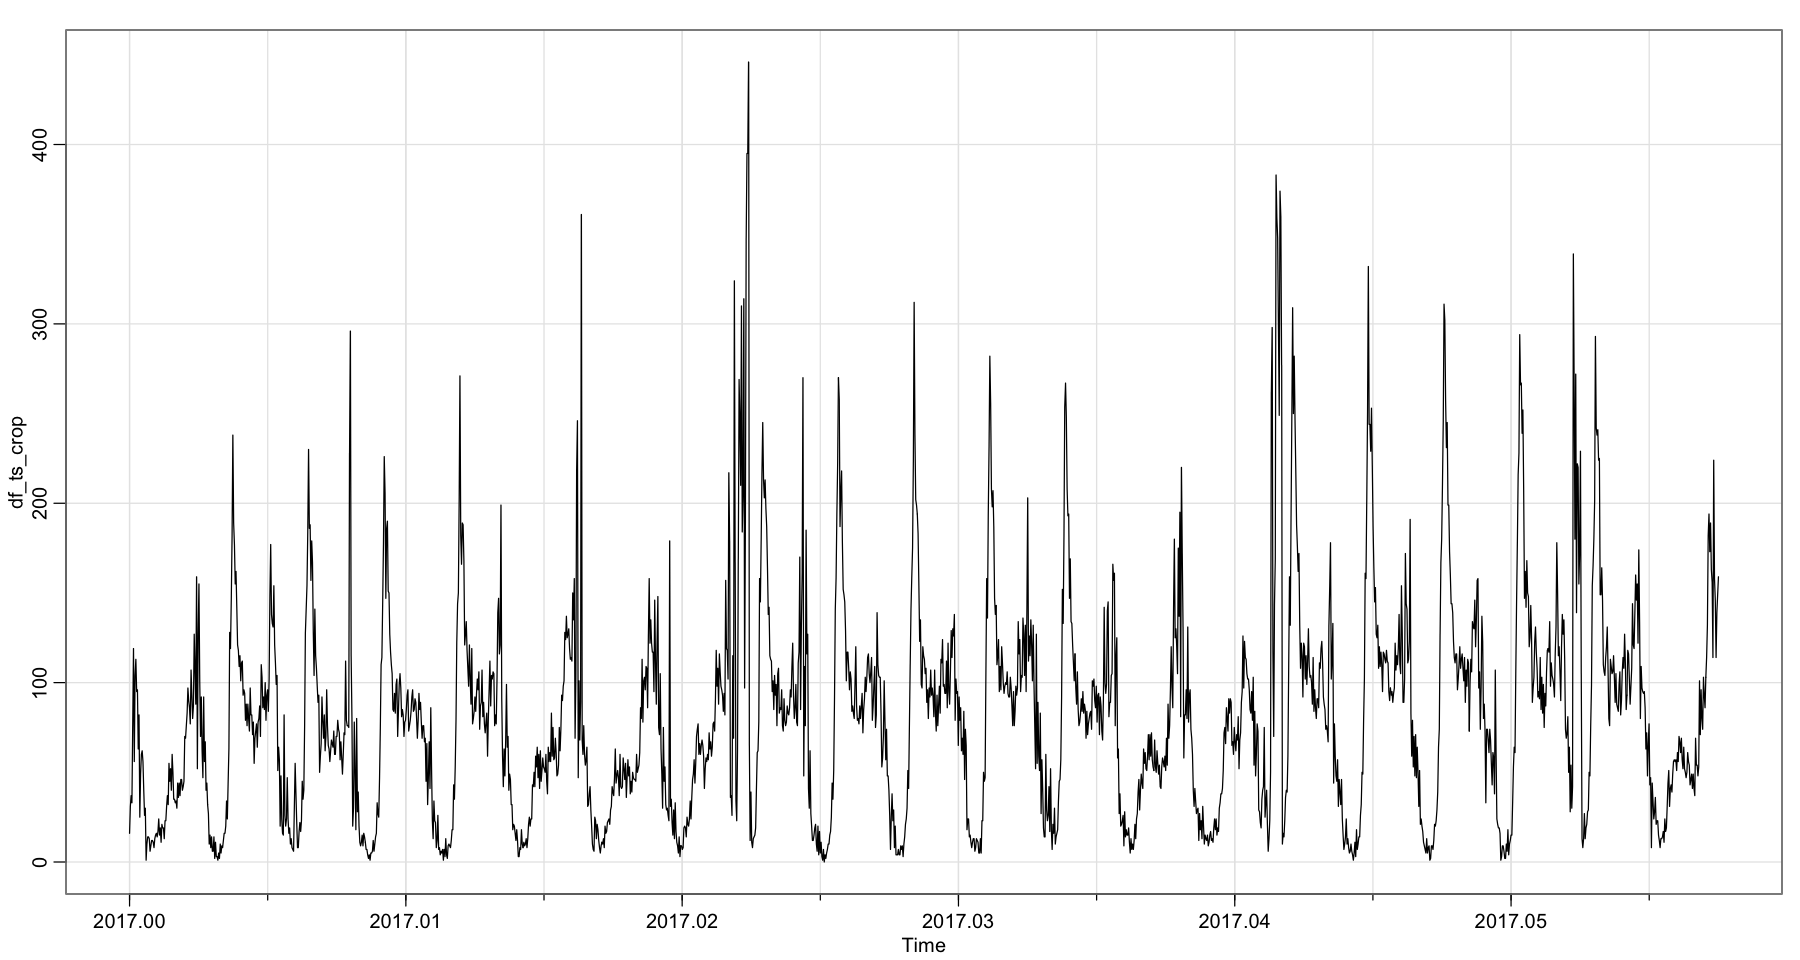

In [5]:
# Plot de la TS
tsplot(df_ts)

# Días a tomar para análisis más pequeño
days_to_crop = 21

# Muestras por día (4 muestras cada 15 minutos x 24)
samples_per_day = 96

# Serie recortada
df_ts_crop = head(df_ts, samples_per_day*days_to_crop)

# Promedio de serie cortada
mean(df_ts_crop)

# Plot de la serie cortada
tsplot(df_ts_crop)


In [6]:
df_aggregate = aggregate(df_ts_aux, nfrequency = freq_aux, FUN = sum)
df_aggregate_ts = ts(df_aggregate, frequency = freq_aux, start=c(2017,1))
#tsplot(df_aggregate_ts)

df_aggregate_ts_croped = head(df_aggregate_ts, (96*7+2)*5)
#length(df_aggregate_ts_croped)
#time(df_aggregate_ts_croped)

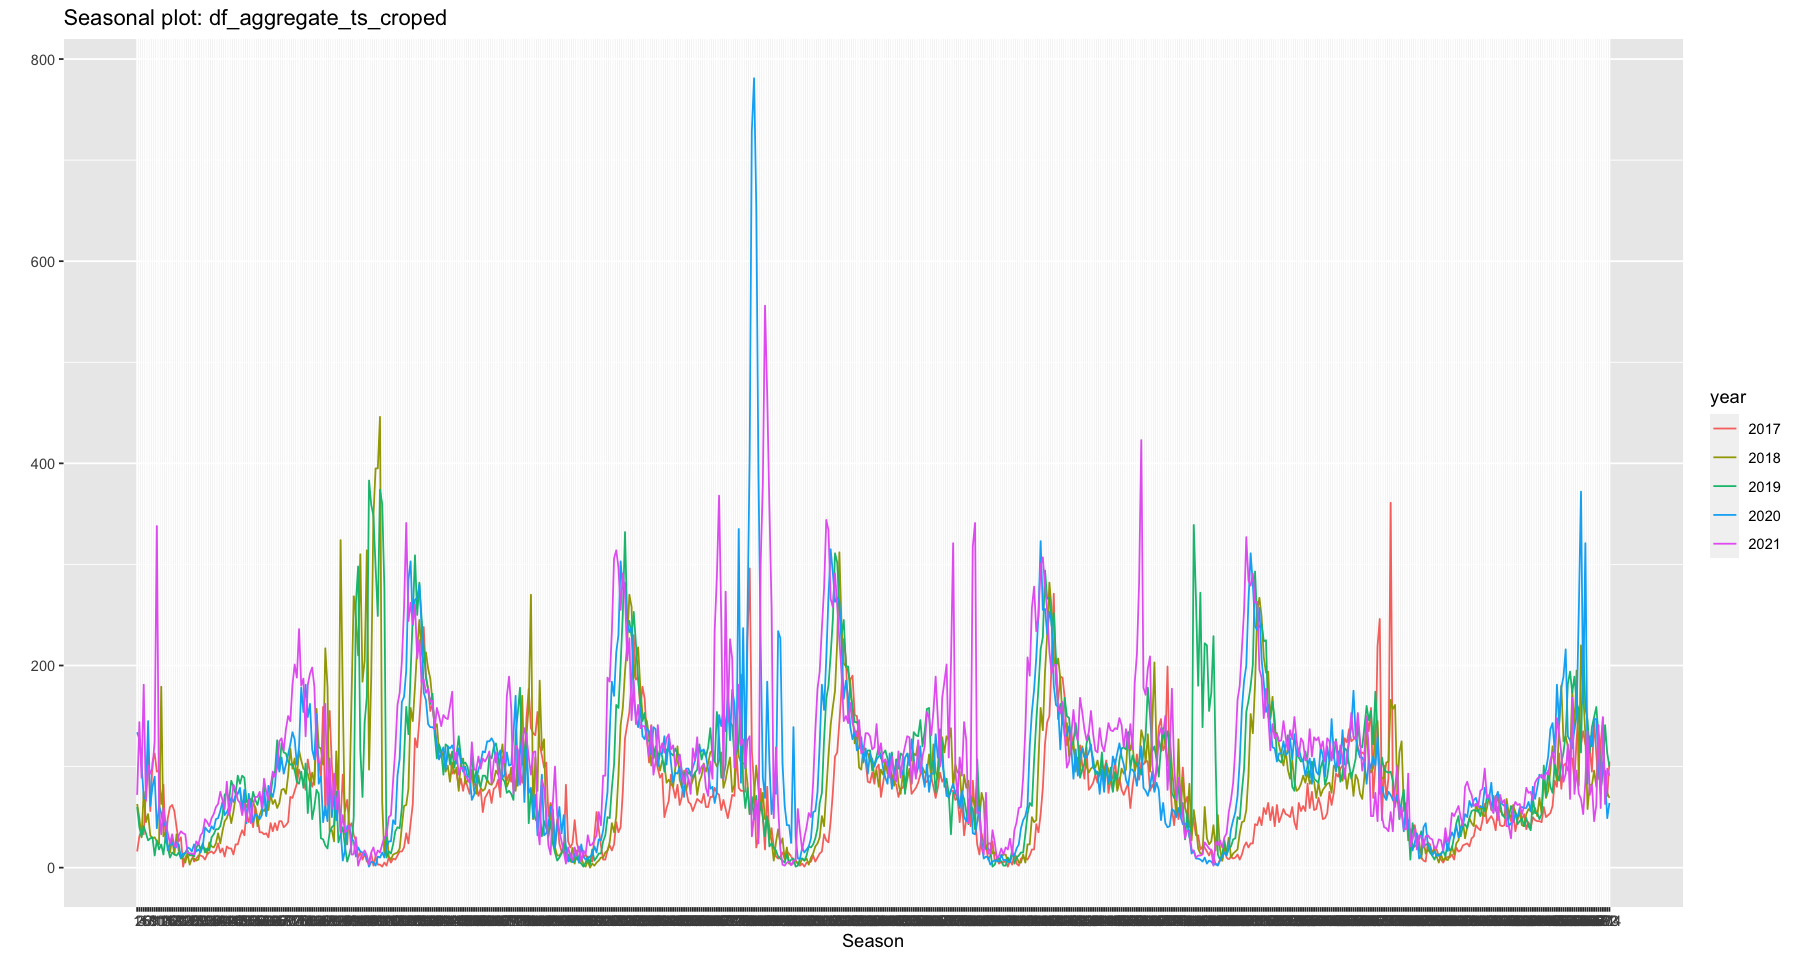

In [7]:
ggseasonplot(df_aggregate_ts_croped)

In [13]:
#gg_season(df_aggregate_ts_croped)# , period = "week"

ERROR: Error in UseMethod("measured_vars"): no applicable method for 'measured_vars' applied to an object of class "ts"


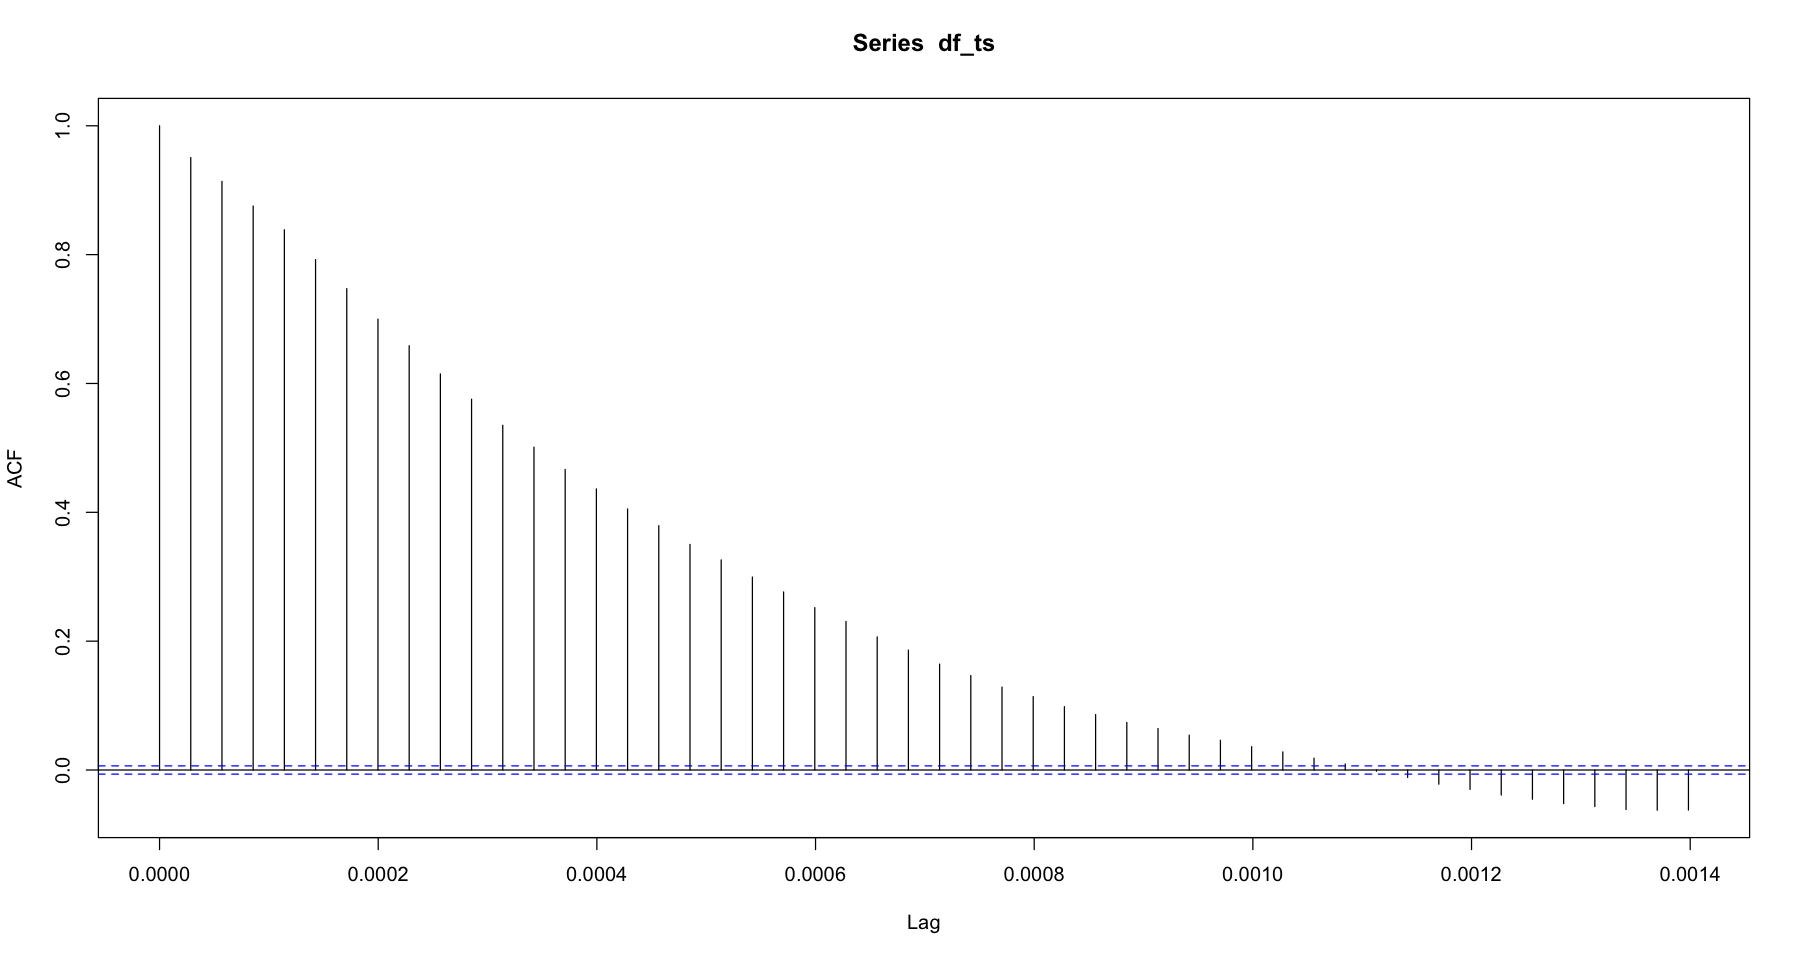

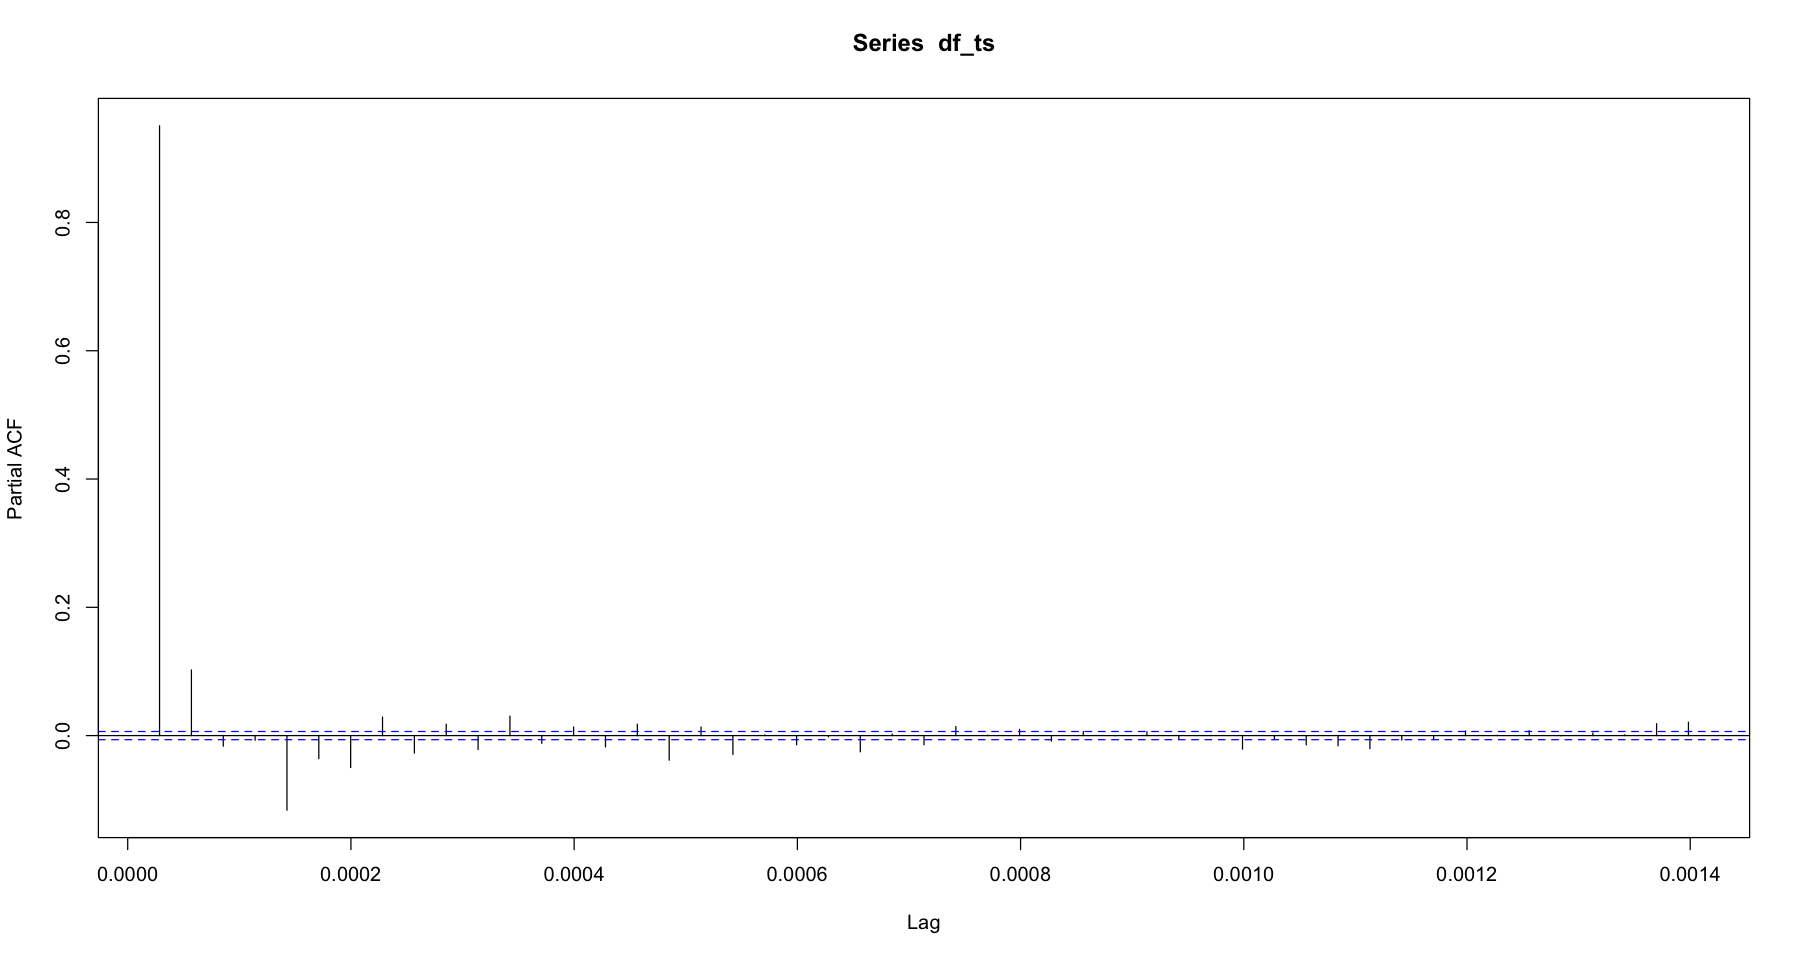

In [8]:
acf(df_ts)
pacf(df_ts)

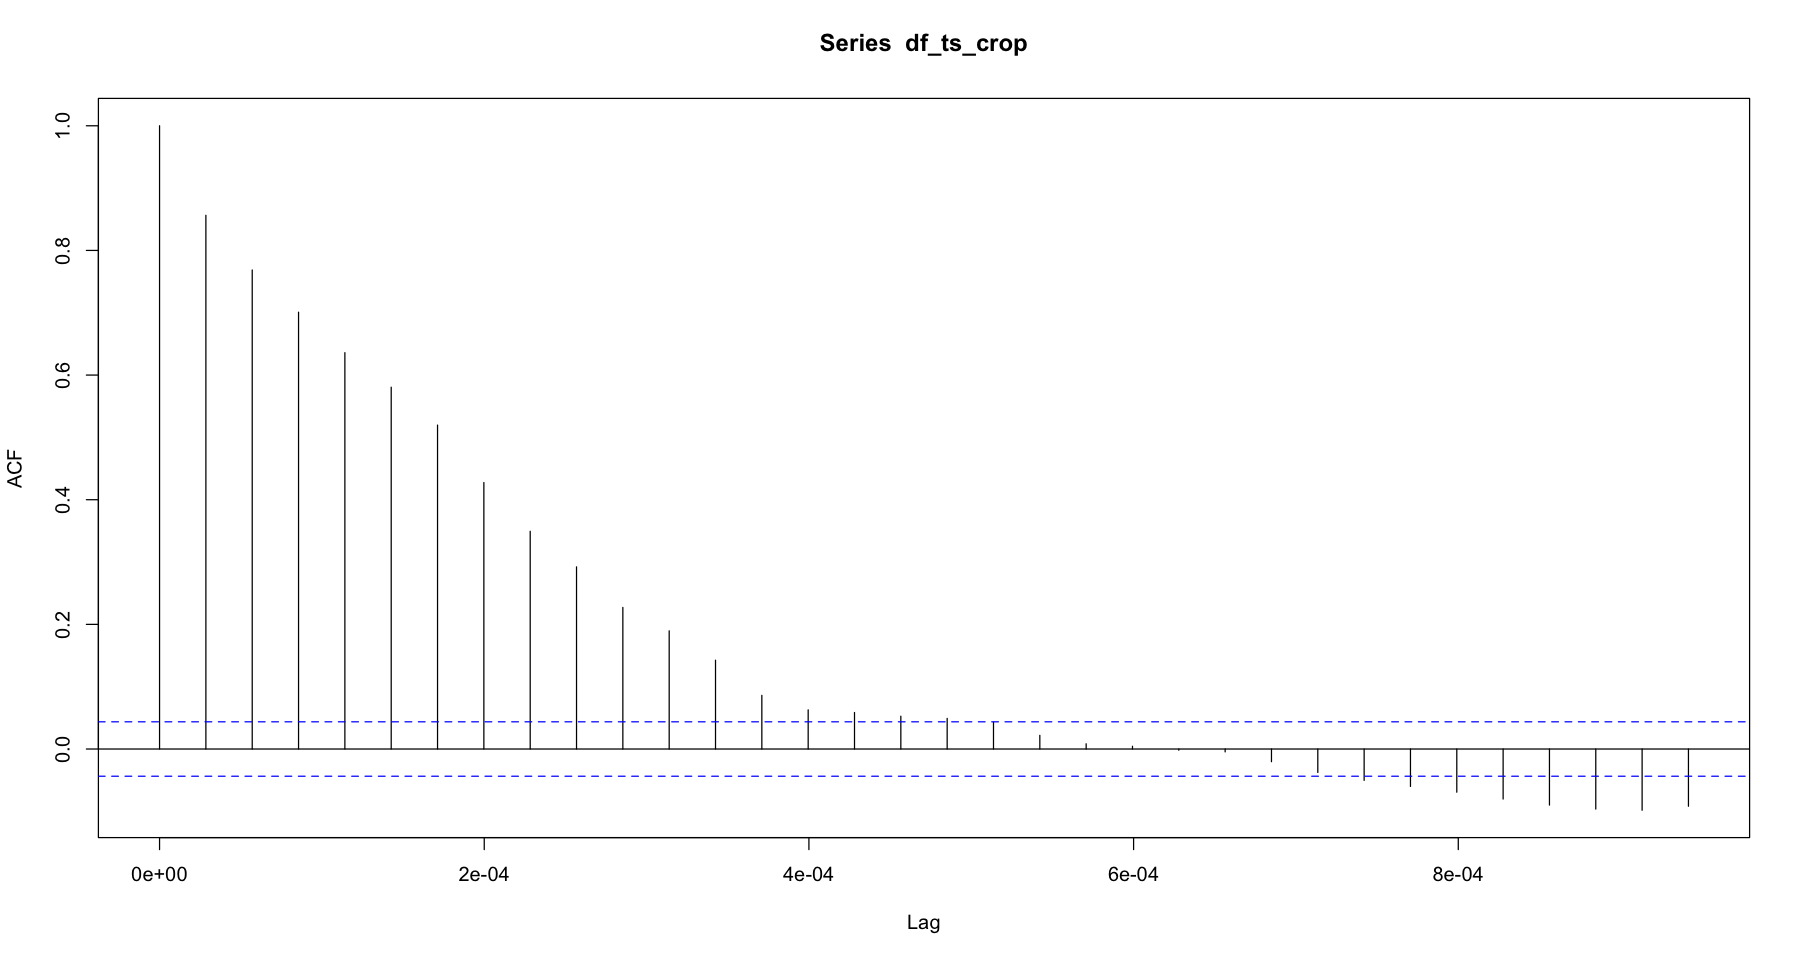

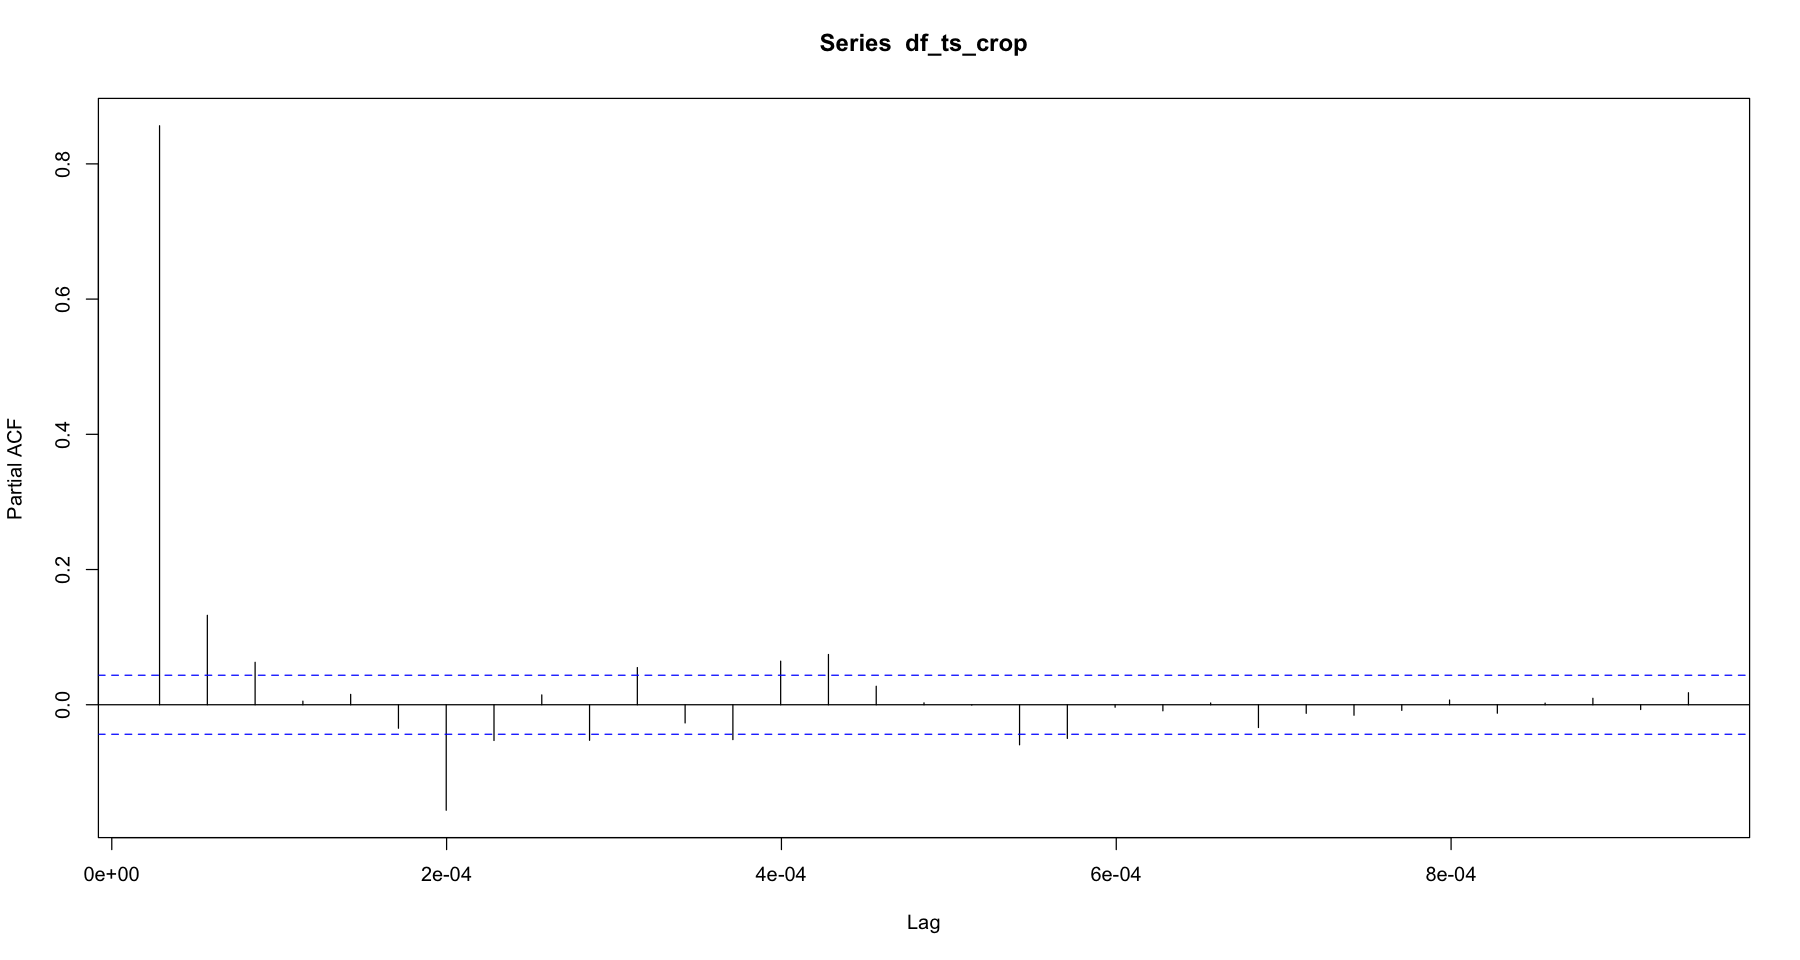

In [9]:
acf(df_ts_crop)
pacf(df_ts_crop)

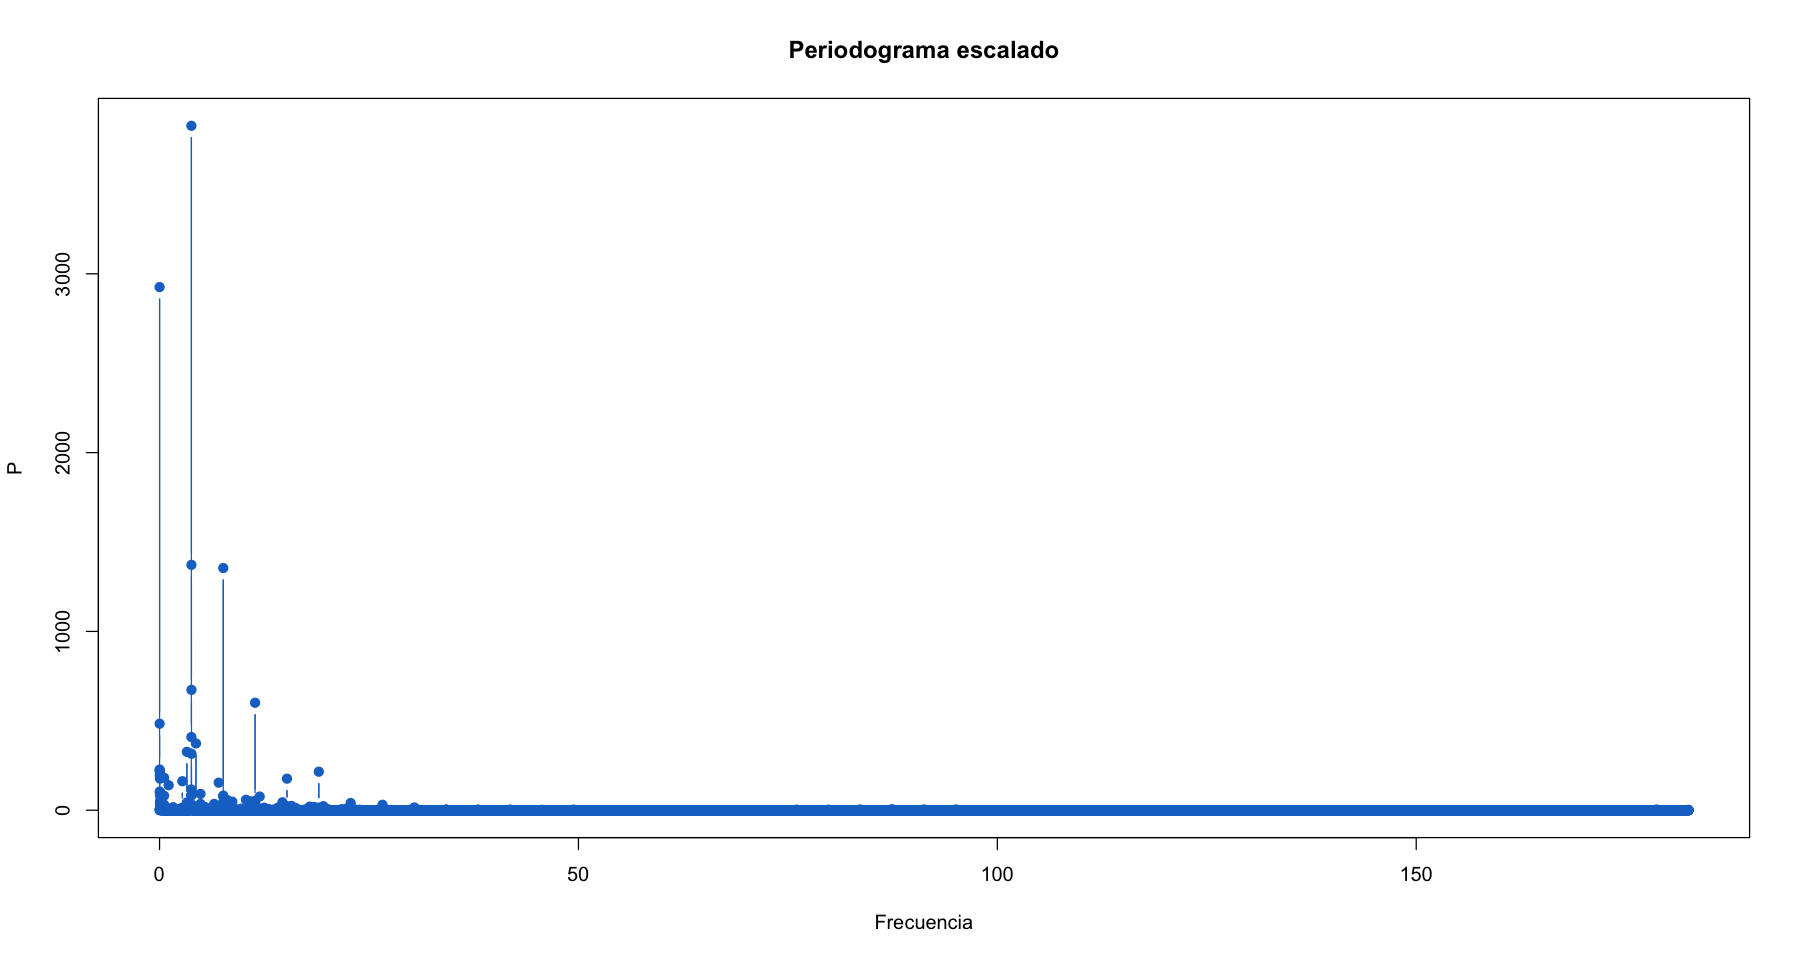

In [10]:
# Estudio de la periodicidad 
freq_periodograma = (24*60)/(3*5) # 24 horas * 60 minutos es la granularidad de minutos por día * 5 minutos por muestra agregado en 3 muestras 
s = df_ts
s = s-mean(s) # Se quita la media
n = length(s)
I = abs(fft(s))^2 #FFT y módulo cuadrado
I = I[1:floor(n/2)] #Recorto el vector a las frecuencias observables
P = (4/n^2)*I #Escalado del periodograma
f = (0:(n/2-1))/n*freq/96 #Vector de frecuencias para hacer el gráfico (se multiplica por la frecuencia de la serie, para normalizar

#Ploteo del periodograma
plot(f, P, type="b", xlab="Frecuencia", main="Periodograma escalado", col=4, lwd=1, pch=19)

In [11]:
# Primera frecuencia de mayor importancia
f1 = f[which.max(P)]*samples_per_day
f1

# Segunda frecuencia de mayor importancia
P[which.max(P)] = 0
f2 = f[which.max(P)]*samples_per_day
f2

# Tercera frecuencia de mayor importancia
P[which.max(P)] = 0
f3 = f[which.max(P)]*samples_per_day
f3

# Cuarta frecuencia de mayor importancia
P[which.max(P)] = 0
f4 = f[which.max(P)]*samples_per_day
f4

# Quinta frecuencia de mayor importancia
P[which.max(P)] = 0
f5 = f[which.max(P)]*samples_per_day
f5

[1] 364.8483

[1] 0.3734374

[1] 365.2217

[1] 730.07

[1] 365.5952


Call:
lm(formula = df_ts_crop ~ t + cos(2 * pi * f1 * t) + sin(2 * 
    pi * f1 * t) + cos(2 * pi * f3 * t) + sin(2 * pi * f3 * t) + 
    cos(2 * pi * f4 * t) + sin(2 * pi * f4 * t))

Residuals:
    Min      1Q  Median      3Q     Max 
-109.23  -29.44   -7.33   15.24  421.81 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.218e+06  1.460e+05  -8.346  < 2e-16 ***
t                     6.040e+02  7.236e+01   8.346  < 2e-16 ***
cos(2 * pi * f1 * t)  8.128e+01  4.366e+01   1.862 0.062780 .  
sin(2 * pi * f1 * t)  8.530e+01  4.360e+01   1.957 0.050544 .  
cos(2 * pi * f3 * t)  9.171e+01  4.362e+01   2.103 0.035628 *  
sin(2 * pi * f3 * t) -1.071e+02  4.363e+01  -2.454 0.014229 *  
cos(2 * pi * f4 * t)  3.321e+01  1.700e+00  19.542  < 2e-16 ***
sin(2 * pi * f4 * t)  6.091e+00  1.698e+00   3.586 0.000344 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53.92 on 2008 degrees of freedom
Multi

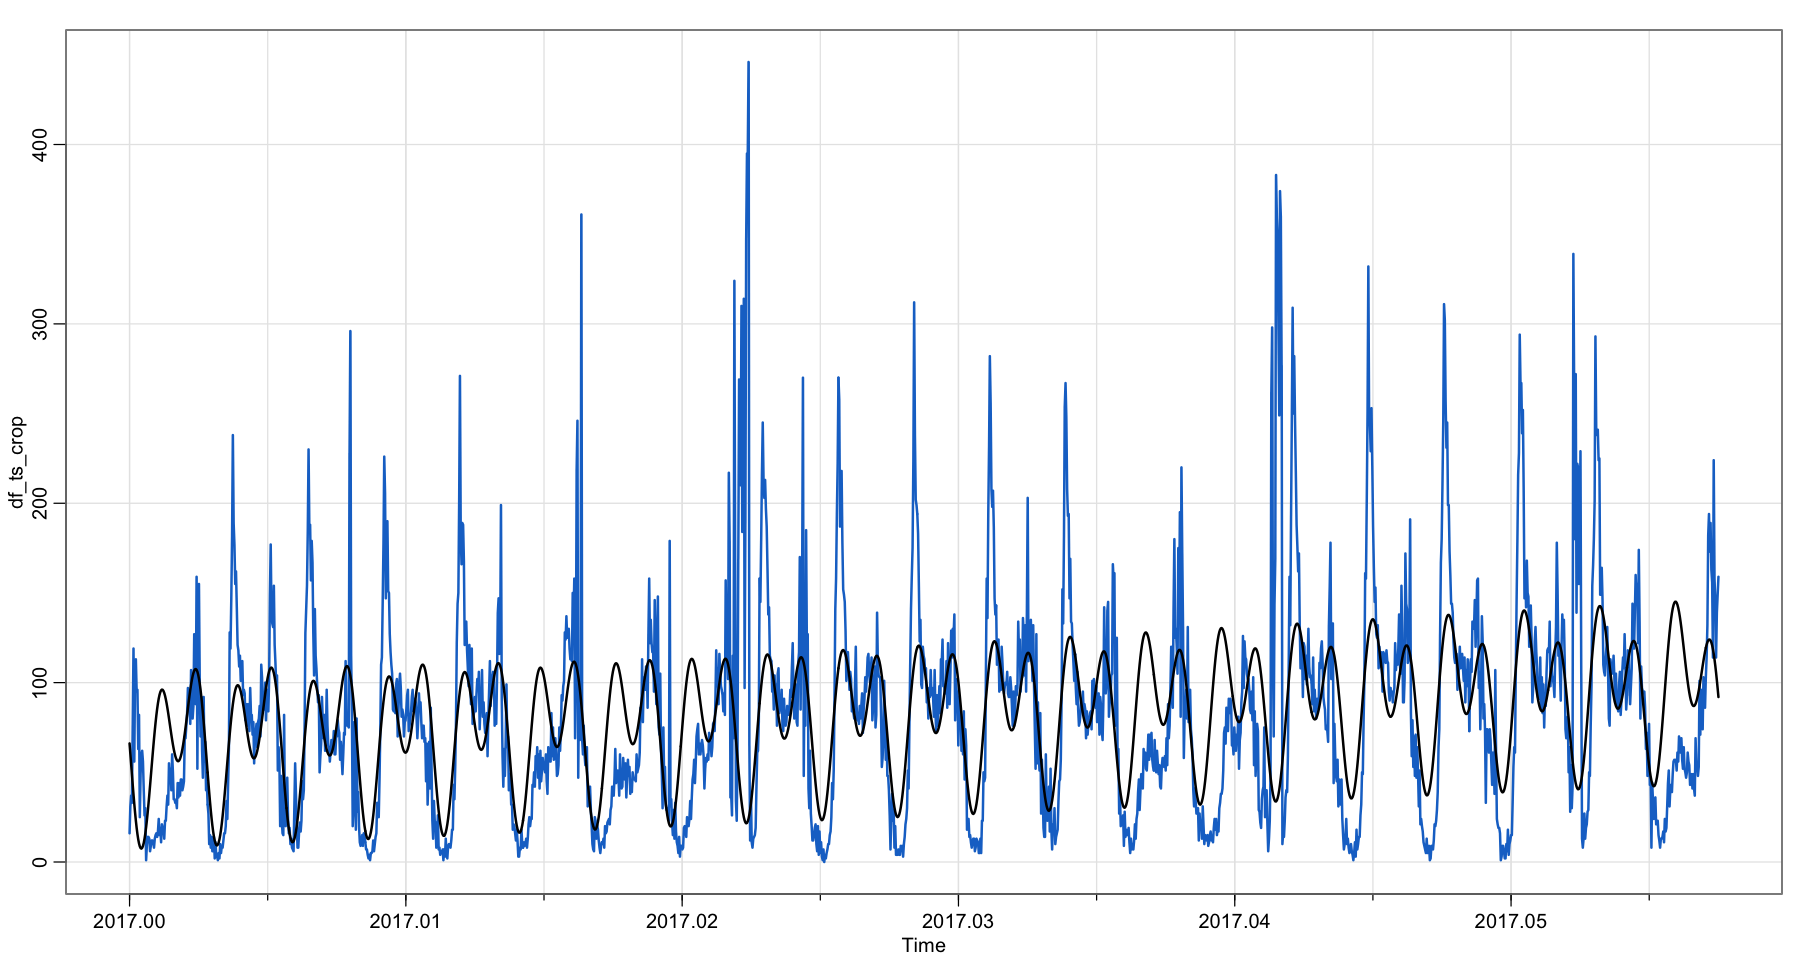

In [12]:
t = time(df_ts_crop)

# Creación de fit con las 3 frecuencias halladas
fit_df_ts_crop = lm(df_ts_crop ~ t + cos(2*pi*f1*t)+sin(2*pi*f1*t)+cos(2*pi*f3*t)+sin(2*pi*f3*t)+cos(2*pi*f4*t)+sin(2*pi*f4*t))

summary(fit_df_ts_crop)

adjustment_fit_df_ts_crop = ts(fitted(fit_df_ts_crop), start=2017, freq=freq)
tsplot(df_ts_crop, col=4, lwd=2)
lines(adjustment_fit_df_ts_crop, lwd=2)

# Residuals del ajuste
residuals_fit = residuals(fit_df_ts_crop)

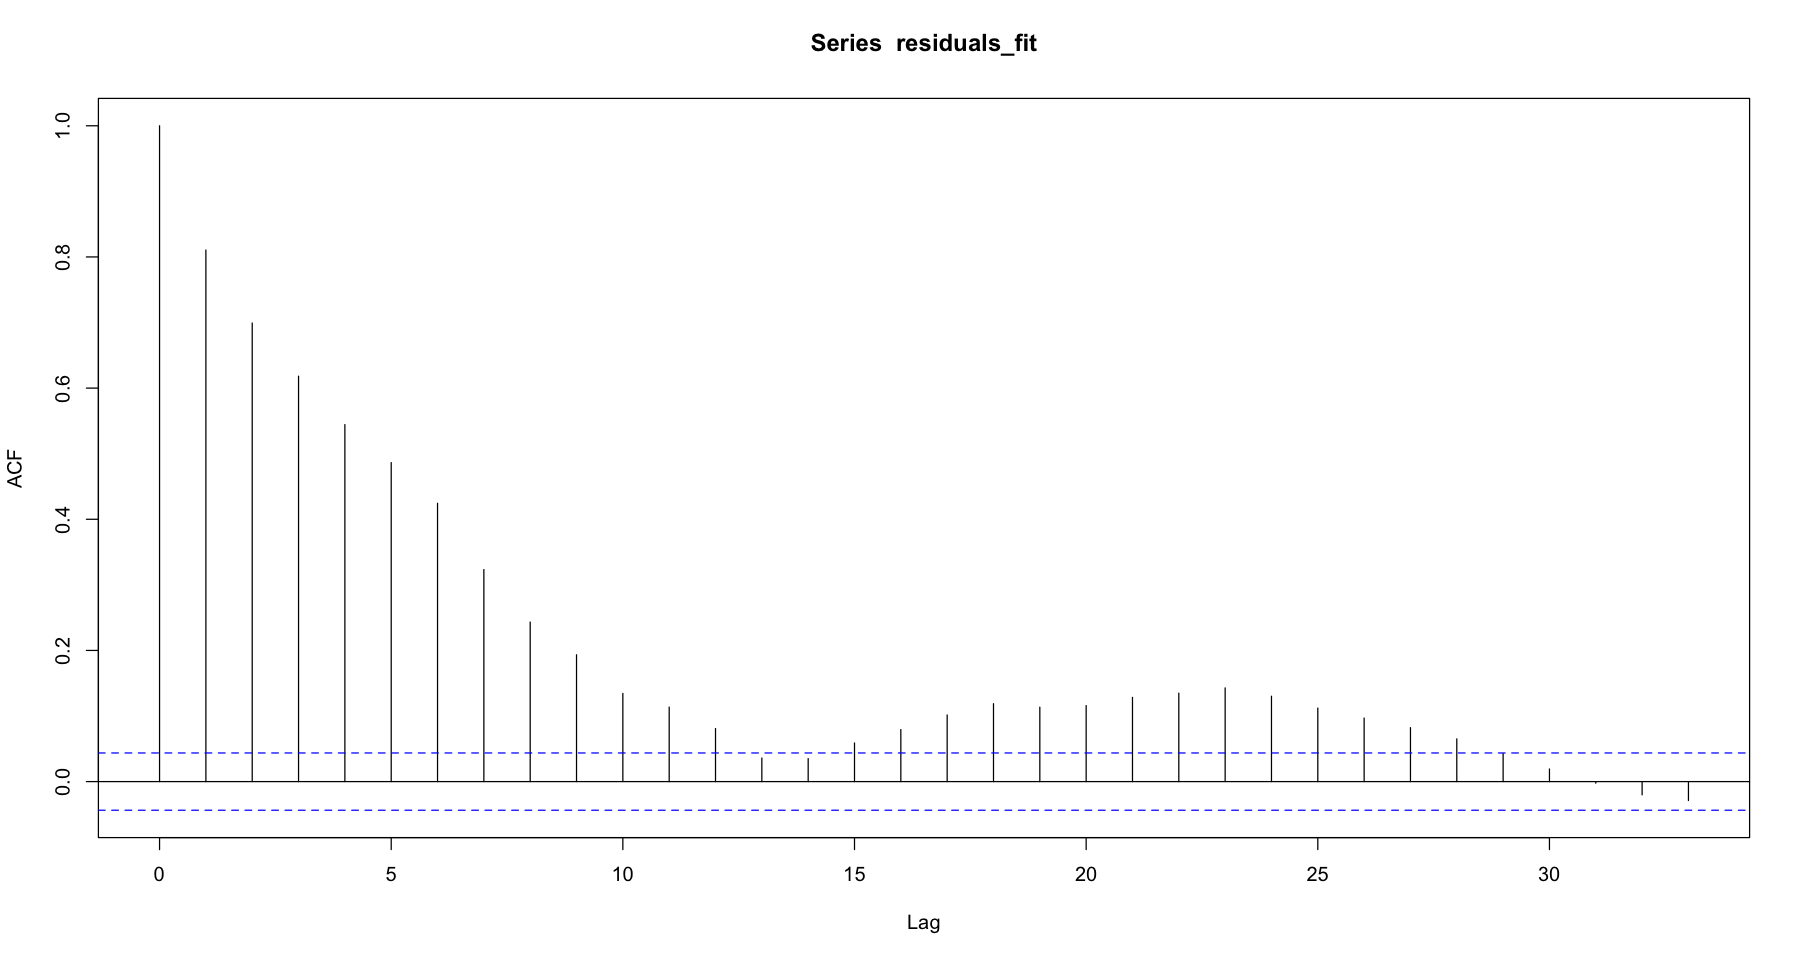

In [13]:
acf(residuals_fit)

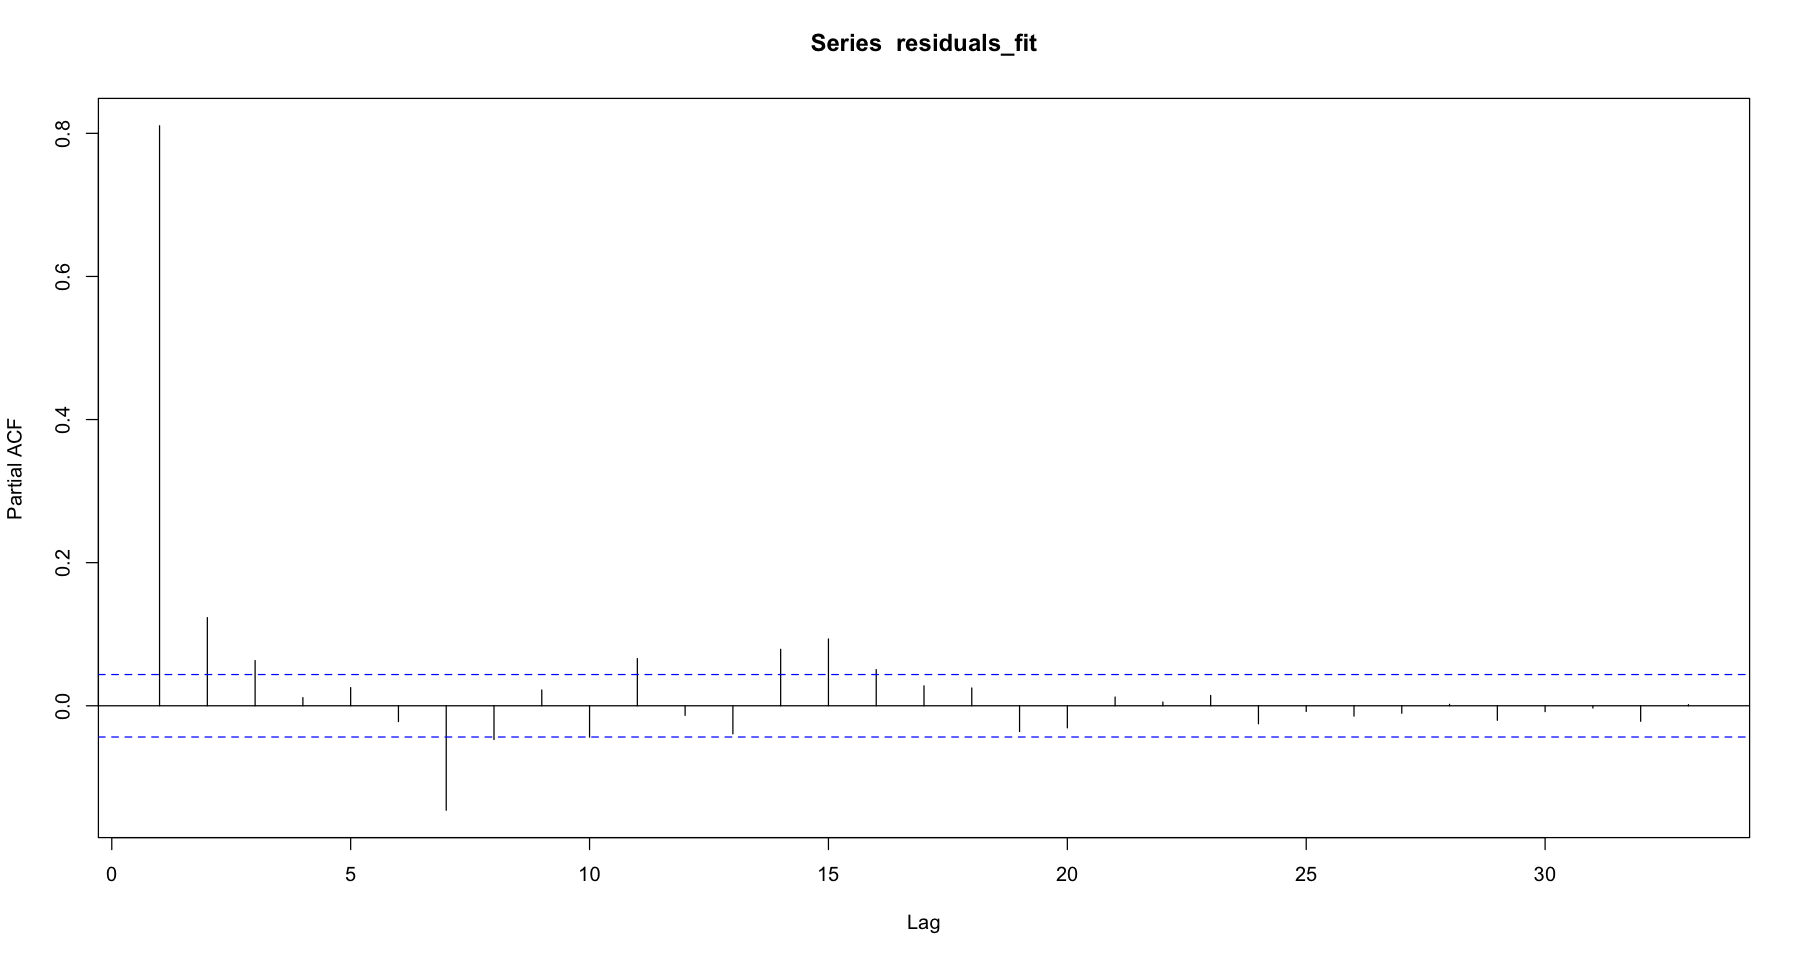

In [14]:
pacf(residuals_fit)

In [ ]:
# Ajuste de ARIMA de AR 2 con Season 1
arima_fit = Arima(df_ts, order=c(2,0,0), seasonal = c(1,0,0), include.mean = FALSE)
summary(arima_fit)
residuals_arima_fit = residuals(arima_fit)
ajuste_arima = ts(fitted(arima_fit), start=2017, freq=freq)

In [ ]:
acf(residuals_arima_fit)
pacf(residuals_arima_fit)
checkresiduals(residuals_arima_fit)

In [15]:
# Auto ARIMA con Seasonal
autoarima = auto.arima(df_ts, seasonal = TRUE)
ajuste_autoarima = ts(fitted(autoarima), start=0, freq=freq)
summary(autoarima)
residuals_autoarima = residuals(autoarima)

Series: df_ts 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.1245
s.e.   0.0032

sigma^2 = 1123:  log likelihood = -462668.2
AIC=925340.4   AICc=925340.4   BIC=925359.3

Training set error measures:
                      ME     RMSE      MAE MPE MAPE      MASE          ACF1
Training set 0.004349234 33.51441 18.89868 NaN  Inf 0.2366368 -0.0004310213

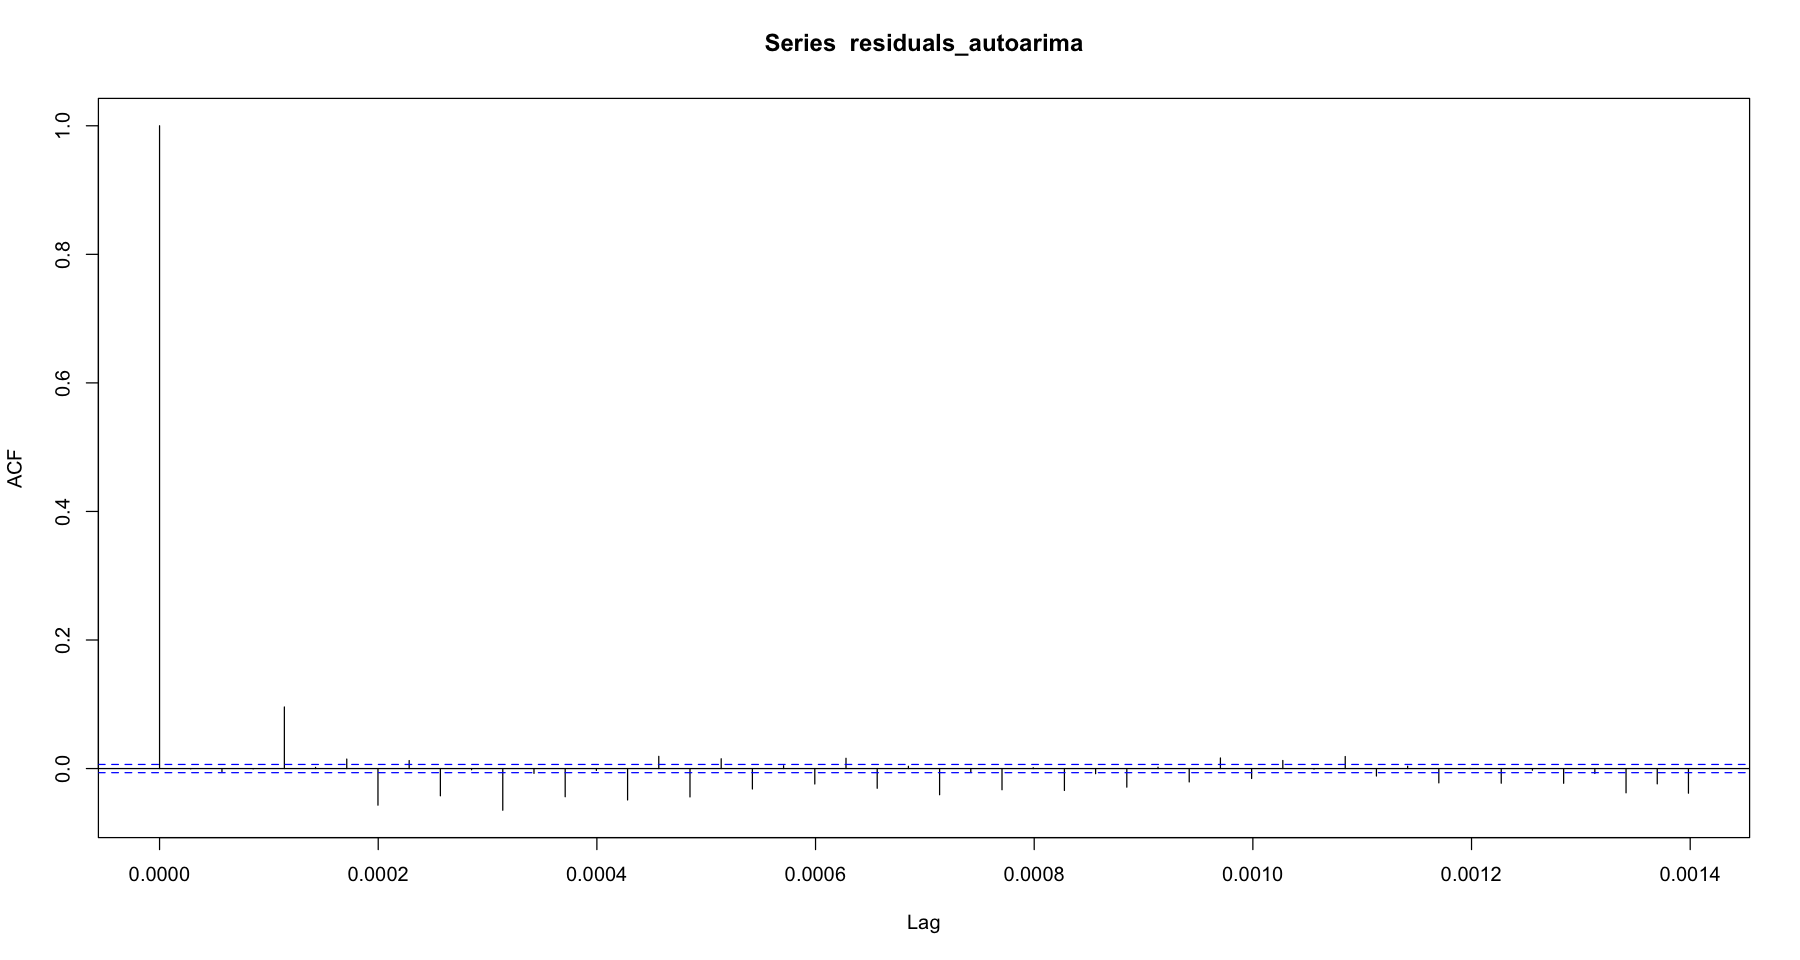

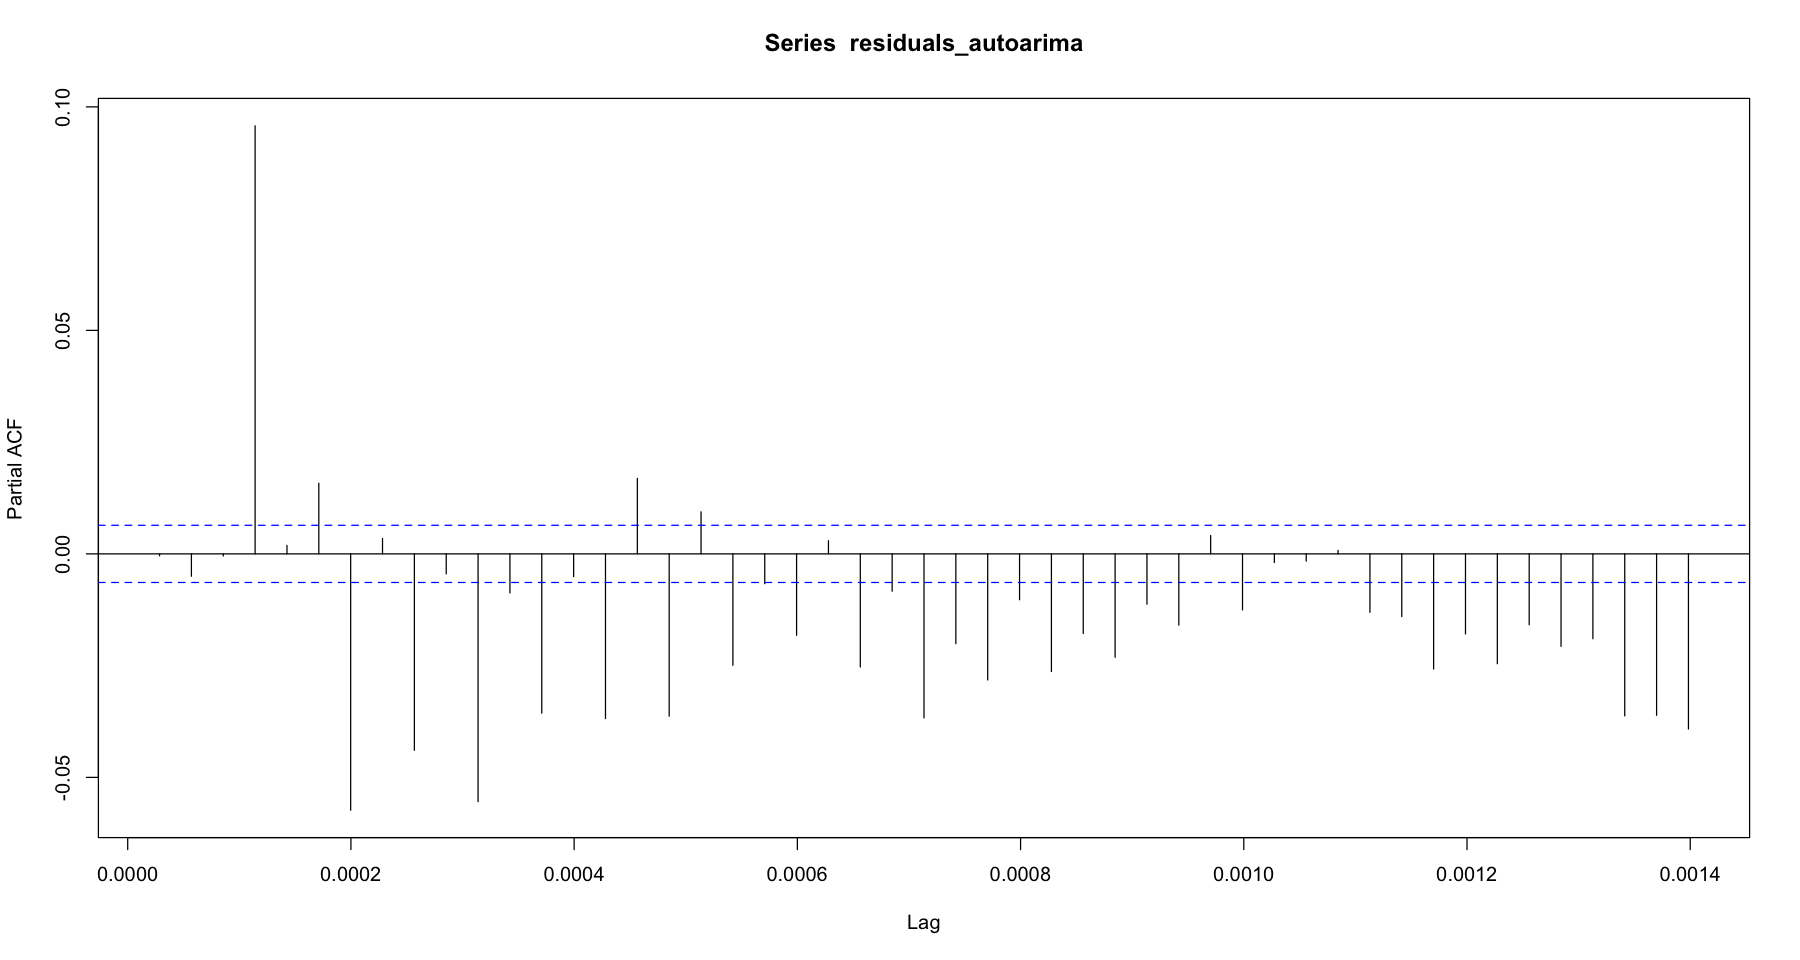

In [16]:
acf(residuals_autoarima)
pacf(residuals_autoarima)